In [1]:
GPU_PKG_NAME = "AMDGPU"; include("common_definitions.jl");

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-14897218164395207370\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-10759577290738369084\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-14897218164395207370\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
using ImageFiltering, ColorTypes, FixedPointNumbers, TensorCore
using FileIO, ImageMagick

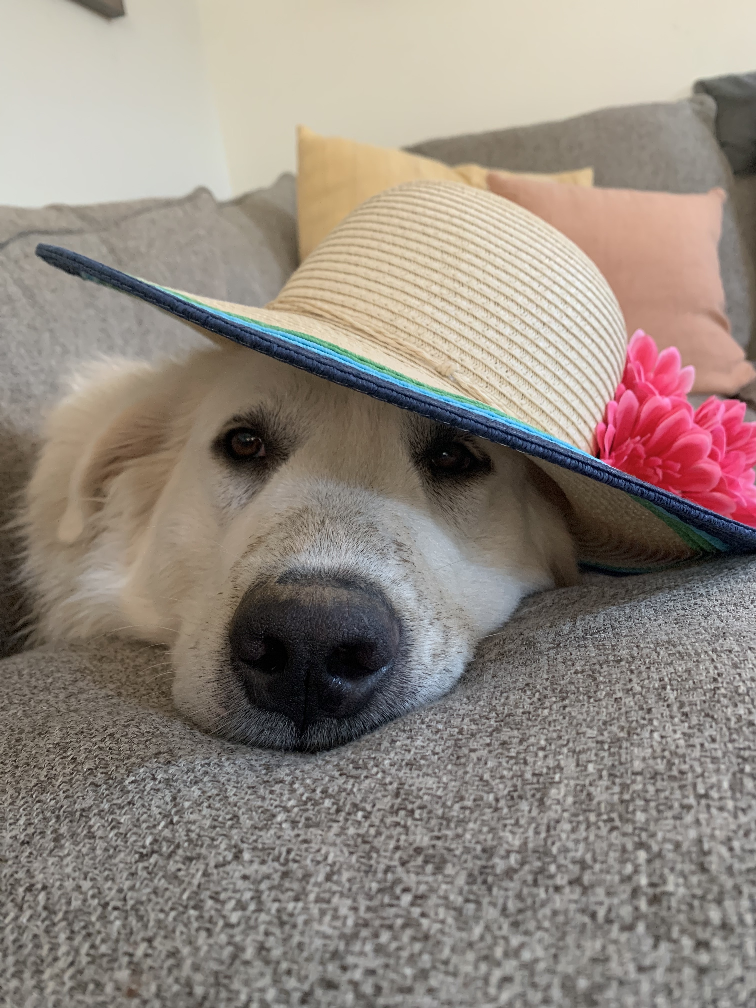

┌ Info: For better quality inline display of large images or thumbnails, load the Images package.
└ @ ImageShow /home/jsamaroo/.julia/packages/ImageShow/11zF7/src/showmime.jl:131


In [3]:
lilly = FileIO.load("Lilly_hat.jpg")

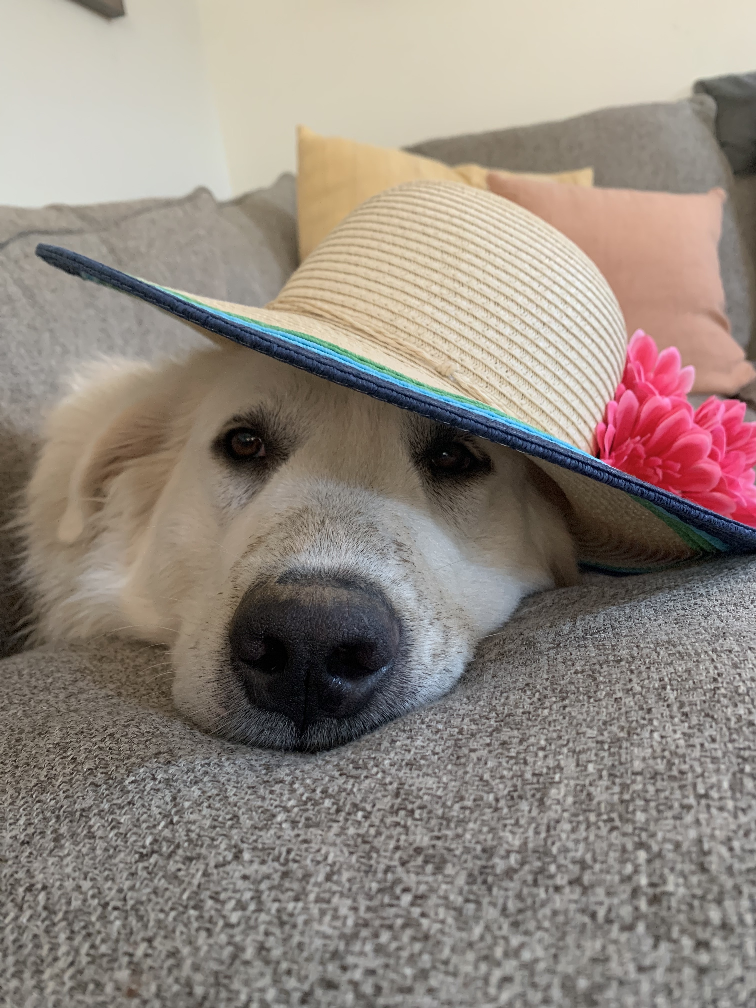

In [4]:
lilly_gpu = GpuArray(map(RGB{Float32}, lilly))
# Let's be careful to not render a GPU array! Scalar indexing is *slow*
Array(lilly_gpu)

Let's do some simple image operations on this image. Let's start with a basic negative:

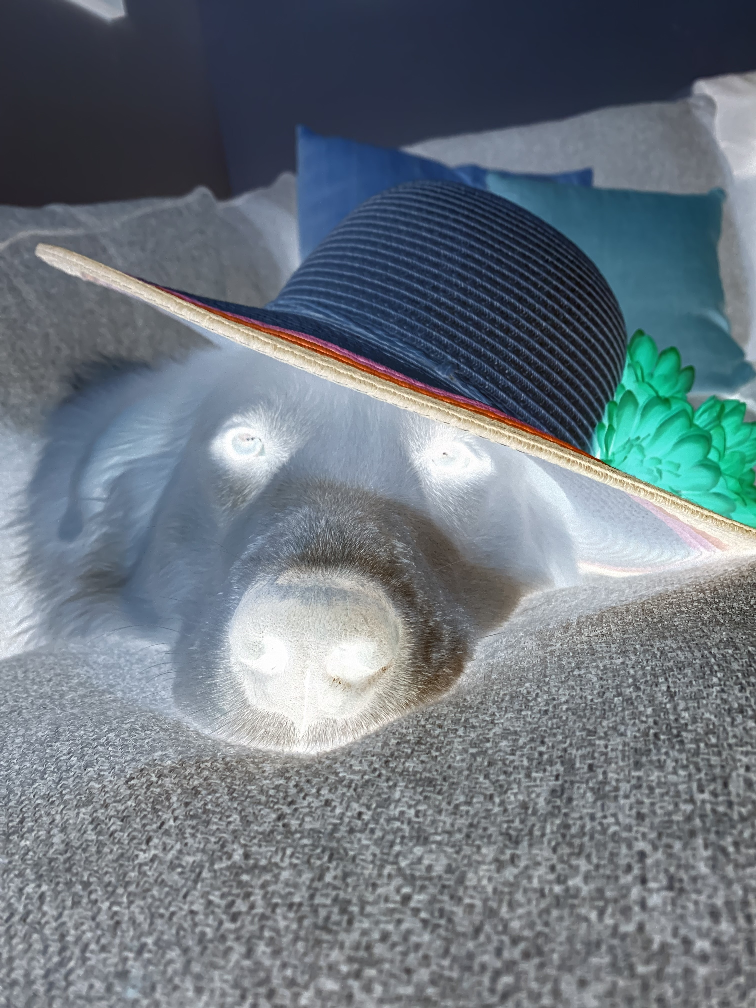

In [5]:
lilly_negative = RGB(1) .- lilly_gpu
Array(lilly_negative)

Cool! We can also adjust the brightness of the image pretty easily:

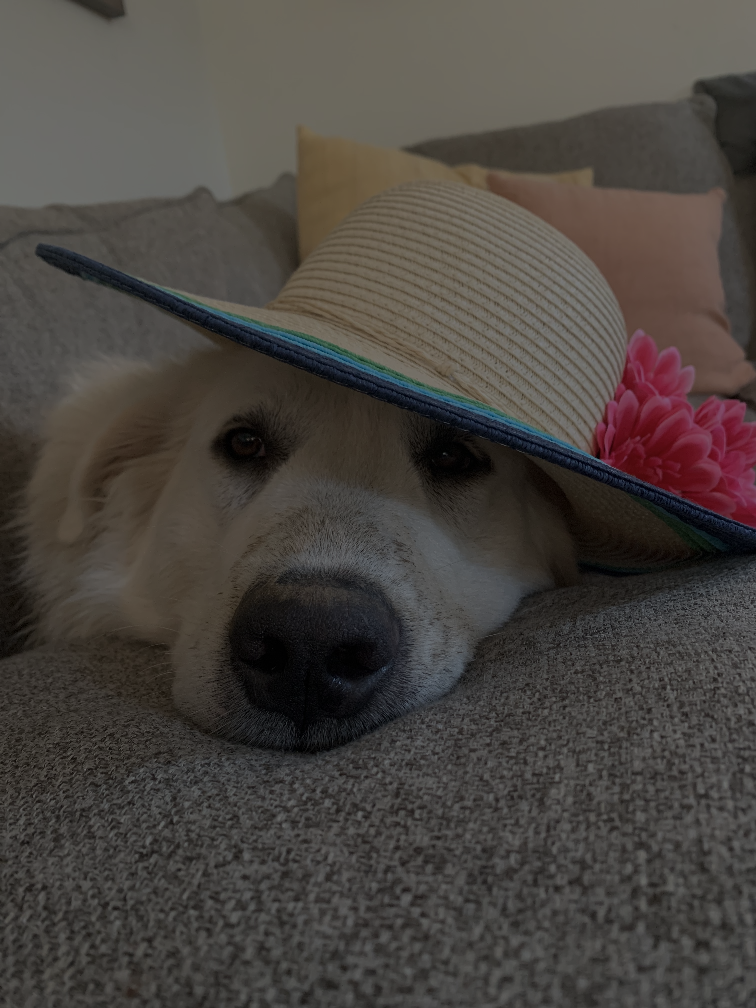

In [6]:
lilly_darker = lilly_gpu .* 0.5
Array(lilly_darker)

Array operations work well for some things, but to get at more complicated operations, we sometimes need to write our operations as GPU kernels directly. Let's implement a basic translation:

In [7]:
@kernel function translate_kernel(out, inp, translation)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = x_idx + translation[1]
    y_outidx = y_idx + translation[2]

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

translate_kernel (generic function with 5 methods)

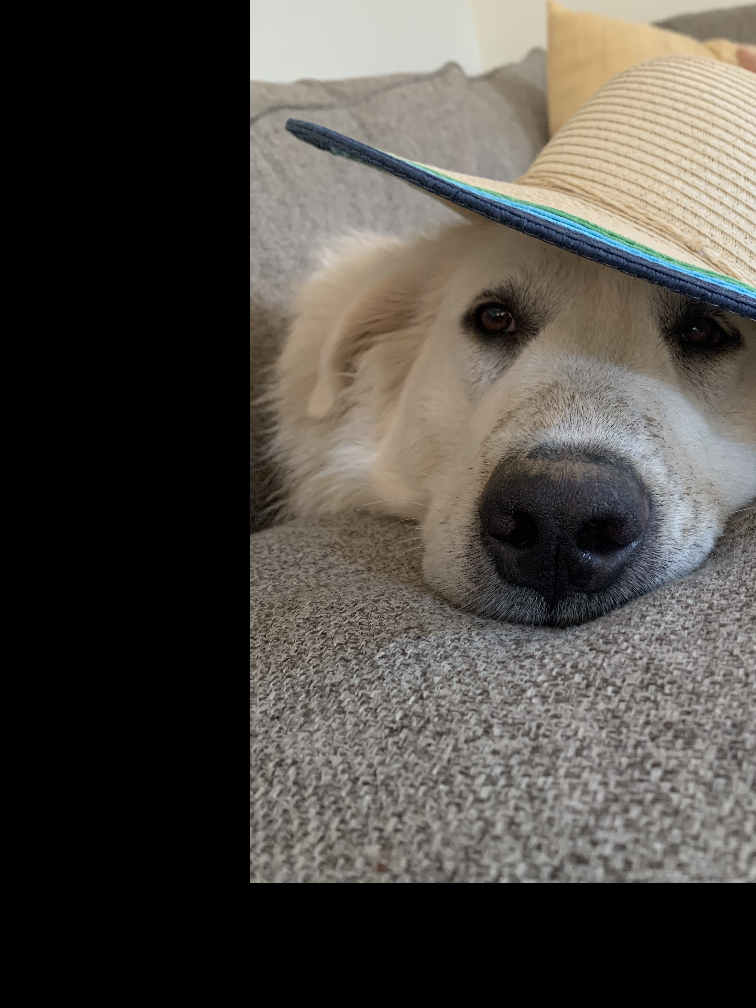

In [9]:
lilly_moved = similar(lilly_gpu)
lilly_moved .= RGB(0)
wait(translate_kernel(GpuBackend)(lilly_moved, lilly_gpu, (-500, 1000); ndrange=size(lilly_gpu), workgroupsize=(32,32)))
Array(lilly_moved)

Great, now let's do a scale operation:

In [10]:
@kernel function scale_kernel(out, inp, scale)
    x_idx, y_idx = @index(Global, NTuple)

    x_outidx = floor(Int, x_idx * scale[1])
    y_outidx = floor(Int, y_idx * scale[2])

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

scale_kernel (generic function with 5 methods)

In [11]:
lilly_scaled = similar(lilly_gpu)
lilly_scaled .= RGB(0)
wait(scale_kernel(GpuBackend)(lilly_scaled, lilly_gpu, (0.5, 0.2); ndrange=size(lilly_gpu), workgroupsize=(32,32)))
Array(lilly_scaled)

LoadError: InvalidIRError: compiling kernel gpu_scale_kernel(Cassette.Context{nametype(ROCCtx), Nothing, Nothing, KernelAbstractions.var"##PassType#257", Nothing, Cassette.DisableHooks}, typeof(gpu_scale_kernel), KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{2, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ROCDeviceMatrix{RGB{Float32}, 1}, ROCDeviceMatrix{RGB{Float32}, 1}, Tuple{Float64, Float64}) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{Int64}, ::Float64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m

Finally, let's rotate this puppy:

In [12]:
@kernel function rotate_kernel(out, inp, angle)
    x_idx, y_idx = @index(Global, NTuple)

    x_centidx = x_idx - (size(inp,1)÷2)
    y_centidx = y_idx - (size(inp,2)÷2)
    x_outidx = round(Int, (x_centidx*cos(angle)) + (y_centidx*-sin(angle)))
    y_outidx = round(Int, (x_centidx*sin(angle)) + (y_centidx*cos(angle)))
    x_outidx += (size(inp,1)÷2)
    y_outidx += (size(inp,2)÷2)

    if (1 <= x_outidx <= size(out,1)) &&
       (1 <= y_outidx <= size(out,2))
        out[x_outidx, y_outidx] = inp[x_idx, y_idx]
    end
end

rotate_kernel (generic function with 5 methods)

In [13]:
lilly_rotated = similar(lilly_gpu)
lilly_rotated .= RGB(0)
wait(rotate_kernel(GpuBackend)(lilly_rotated, lilly_gpu, deg2rad(145); ndrange=size(lilly_gpu), workgroupsize=(32,32)))
Array(lilly_rotated)

LoadError: InvalidIRError: compiling kernel gpu_rotate_kernel(Cassette.Context{nametype(ROCCtx), Nothing, Nothing, KernelAbstractions.var"##PassType#257", Nothing, Cassette.DisableHooks}, typeof(gpu_rotate_kernel), KernelAbstractions.CompilerMetadata{KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicCheck, Nothing, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, KernelAbstractions.NDIteration.NDRange{2, KernelAbstractions.NDIteration.DynamicSize, KernelAbstractions.NDIteration.DynamicSize, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, CartesianIndices{2, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}}}, ROCDeviceMatrix{RGB{Float32}, 1}, ROCDeviceMatrix{RGB{Float32}, 1}, Float64) resulted in invalid LLVM IR
Reason: unsupported call to the Julia runtime (call to jl_f_tuple)
Stacktrace:
 [1] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:632[0m
 [2] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m
Reason: unsupported call to the Julia runtime (call to jl_f_getfield)
Stacktrace:
 [1] [0m[1mInexactError(::Symbol, ::Type{Int64}, ::Float64)[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [2] [0m[1moverdub[22m
[90m   @ [39m[90m./[39m[90;4mboot.jl:310[0m
 [3] [0m[1moverdub[22m
[90m   @ [39m[90m~/.julia/packages/Cassette/N5kbV/src/[39m[90;4moverdub.jl:0[0m
 [4] [0m[1mmultiple call sites[22m
[90m   @ [39m[90;4munknown:0[0m

Awesome! Those 3 operations are foundational to image processing, and they were easy to implement in Julia! However, there are plenty of other useful operators. How about we implement a Gaussian filter so we can get a blurry puppy?

We can use ImageFiltering to generate the kernels for us on the CPU, and then we just need to massage them into something that'll work on the GPU:

In [14]:
gaussian_k = Kernel.gaussian(15)
gaussian_kG = GpuArray(map(x->RGB{Float32}(Gray(x)), gaussian_k.parent))
gaussian_offsets = abs.(gaussian_k.offsets) .- 1

(30, 30)

And now we need to write out GPU kernel. We're going to implement a correlation (often incorrectly called a convolution) operation, which we can use to apply a filtering kernel to an input image:

In [15]:
@kernel function corr_kernel(out, inp, kern, offsets)
    x_idx, y_idx = @index(Global, NTuple)

    out_T = eltype(out)

    if (1 <= x_idx <= size(out,1)) && (1 <= y_idx <= size(out,2))
        x_toff, y_toff = offsets

        # create our accumulator
        acc = zero(out_T)

        # iterate in column-major order for efficiency
        for y_off in -y_toff:1:y_toff, x_off in -x_toff:1:x_toff
            y_inpidx, x_inpidx = y_idx+y_off, x_idx+x_off
            if (1 <= y_inpidx <= size(inp,2)) && (1 <= x_inpidx <= size(inp,1))
                y_kernidx, x_kernidx = y_off+y_toff+1, x_off+x_toff+1
                acc += hadamard(inp[x_inpidx, y_inpidx],
                                kern[x_kernidx, y_kernidx])
            end
        end
        out[x_idx, y_idx] = acc
    end
end

corr_kernel (generic function with 5 methods)

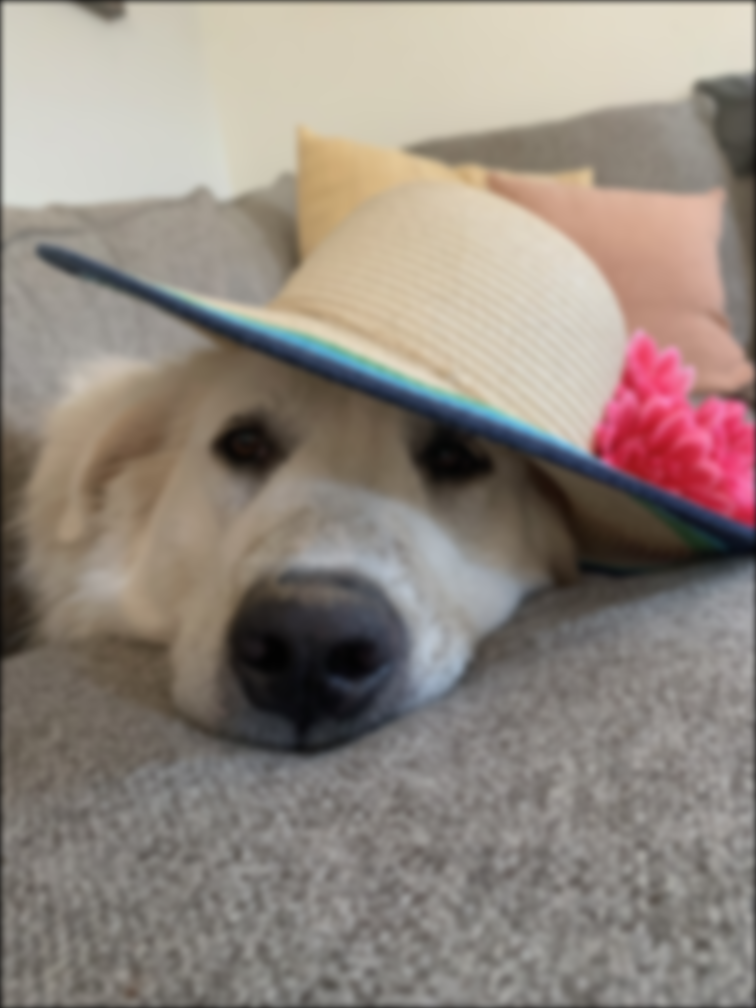

In [16]:
lilly_blurry = similar(lilly_gpu)
wait(corr_kernel(GpuBackend)(lilly_blurry, lilly_gpu, gaussian_kG, gaussian_offsets; ndrange=size(lilly_gpu), workgroupsize=(32,32)))
Array(lilly_blurry)

There are plenty of interesting features in this image. Let's use a Sobel filter to see what the edges in the image look like. Note that a Sobel filtering operation actually uses two filter kernels, but we can get a good idea with just one of them.

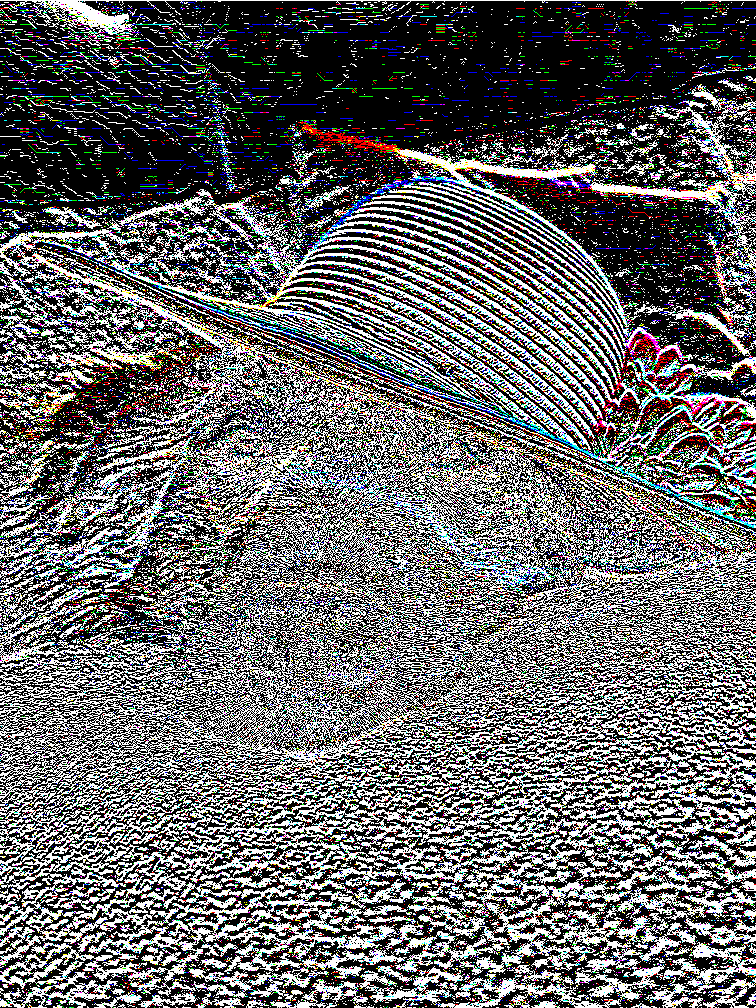

In [17]:
sobel_k = Kernel.sobel()
sobel_kG = GpuArray(map(RGB{Float32}, sobel_k[1].parent))
sobel_offsets = abs.(sobel_k[1].offsets) .- 1

lilly_sobel = similar(lilly_gpu)
wait(corr_kernel(GpuBackend)(lilly_sobel, lilly_gpu, sobel_kG, sobel_offsets; ndrange=size(lilly_gpu), workgroupsize=(32,32)))
# Post-process the Sobel gradients into something comprehendable by humans
lilly_sobel = map(x->mapc(y->y > 0 ? 1.0 : 0.0, x), lilly_sobel)
Array(lilly_sobel)